# Causal Inference

In [8]:
!pip install econml
!pip install dowhy
!pip install -U econml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 398.4/398.4 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 kB 17.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 59.5 MB/s eta 0:00:00
  Attempting uninstall: cython
    Found existing installation: Cython 3.0.12
    Uninstalling Cython-3.0.12:
      Successfully uninstalled Cython-3.0.12


In [24]:
!apt-get update
!apt-get install -y graphviz libgraphviz-dev pkg-config
!pip install pygraphviz
!pip install pydot
!pip install -U dowhy

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,632 B]
Hit:2 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [128 kB]
Get:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease [1,581 B]
Get:5 http://security.ubuntu.com/ubuntu jammy-security InRelease [129 kB]
Get:6 https://r2u.stat.illinois.edu/ubuntu jammy InRelease [6,555 B]
Get:7 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [127 kB]
Hit:8 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:10 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  Packages [1,319 kB]
Get:12 https://r2u.stat.illinois.edu/ubuntu jammy/main amd64 Packages [2,661 kB]
Get:13 http://archive.ubuntu.com/ubuntu jammy-up

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from econml.dml import LinearDML, CausalForestDML
from econml.metalearners import XLearner, TLearner, SLearner
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
import dowhy
from dowhy import CausalModel
import networkx as nx
from IPython.display import display
import warnings
warnings.filterwarnings('ignore')

In [14]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [17]:
# Load the preprocessed training dataset
train = pd.read_csv('/content/drive/MyDrive/Processed_train.csv')

print("Dataset dimensions:", train.shape)
print("Columns:", train.columns.tolist())

# Basic dataset statistics
print("\nBasic dataset statistics:")
print(f"No-show rate: {train['No-show'].mean():.4f}")
print(f"SMS received rate: {train['SMS_received'].mean():.4f}")
print(f"Scholarship rate: {train['Scholarship'].mean():.4f}")
print(f"Average wait time: {train['WaitTime'].mean():.2f} days")

Dataset dimensions: (88421, 117)
Columns: ['PatientId', 'AppointmentID', 'Gender', 'ScheduledDay', 'AppointmentDay', 'Age', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show', 'WaitTime', 'WaitTime_Log', 'WaitTime_Std', 'WaitTime_MinMax', 'WaitTime_Age_Interaction', 'poly_0', 'poly_1', 'poly_2', 'poly_3', 'AppointmentDay_Day', 'AppointmentDay_Month', 'AppointmentDay_Weekday', 'WaitTime_RollingMean_3', 'WaitTime_Lag_1', 'Gender_Encoded', 'NB_ANDORINHAS', 'NB_ANTÔNIO HONÓRIO', 'NB_ARIOVALDO FAVALESSA', 'NB_BARRO VERMELHO', 'NB_BELA VISTA', 'NB_BENTO FERREIRA', 'NB_BOA VISTA', 'NB_BONFIM', 'NB_CARATOÍRA', 'NB_CENTRO', 'NB_COMDUSA', 'NB_CONQUISTA', 'NB_CONSOLAÇÃO', 'NB_CRUZAMENTO', 'NB_DA PENHA', 'NB_DE LOURDES', 'NB_DO CABRAL', 'NB_DO MOSCOSO', 'NB_DO QUADRO', 'NB_ENSEADA DO SUÁ', 'NB_ESTRELINHA', 'NB_FONTE GRANDE', 'NB_FORTE SÃO JOÃO', 'NB_FRADINHOS', 'NB_GOIABEIRAS', 'NB_GRANDE VITÓRIA', 'NB_GURIGICA', 'NB_HORTO', 'NB_ILHA DAS CAIEIRAS', 'NB_IL

In [18]:
# Create binary WaitTime indicator for easier causal analysis
median_wait = train['WaitTime'].median()
train['HighWaitTime'] = (train['WaitTime'] > median_wait).astype(int)
print(f"Median wait time: {median_wait:.2f} days")

Median wait time: 3.00 days


In [30]:

# =======================================================
# Visual representation of causal relationships
# =======================================================
# Since DoWhy graph parsing has issues, we'll create a custom visualization

# Create SMS causal graph
G_sms = nx.DiGraph()
# Add nodes
nodes = ['Age', 'Gender_Encoded', 'Hipertension', 'Diabetes', 'SMS_received',
         'No-show', 'WaitTime', 'Scholarship', 'Cluster_KMeans_2']
G_sms.add_nodes_from(nodes)

# Add edges
edges = [
    ('Age', 'No-show'), ('Gender_Encoded', 'No-show'),
    ('Hipertension', 'No-show'), ('Diabetes', 'No-show'),
    ('SMS_received', 'No-show'), ('Age', 'SMS_received'),
    ('Hipertension', 'SMS_received'), ('Diabetes', 'SMS_received'),
    ('WaitTime', 'SMS_received'), ('Scholarship', 'SMS_received'),
    ('Scholarship', 'No-show'), ('Cluster_KMeans_2', 'No-show'),
    ('Cluster_KMeans_2', 'SMS_received')
]
G_sms.add_edges_from(edges)

# Visualize the causal graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(G_sms, seed=42)
nx.draw_networkx(
    G_sms,
    pos=pos,
    arrows=True,
    with_labels=True,
    node_color='lightblue',
    node_size=2000,
    font_size=10,
    font_weight='bold'
)
plt.title("Causal Graph for SMS Reminders")
plt.axis('off')
plt.savefig('sms_causal_graph.png')
plt.close()

## Question 1: Do SMS reminders causally reduce no-show rates?

In [21]:
print("\n\n===============================================")
print("Question 1: Do SMS reminders causally reduce no-show rates?")
print("===============================================")

# 1.1 Initial exploration
print("\n1.1 No-show rates by SMS status:")
sms_groups = train.groupby('SMS_received')['No-show'].agg(['mean', 'count'])
print(sms_groups)

# 1.2 Visualization of no-show rates by SMS status
plt.figure(figsize=(10, 6))
sns.barplot(x='SMS_received', y='No-show', data=train, errorbar=('ci', 95))
plt.title('No-show Rate by SMS Status')
plt.xlabel('SMS Received')
plt.ylabel('No-show Probability')
plt.xticks([0, 1], ['No SMS', 'SMS Received'])
plt.savefig('sms_noshow_plot.png')
plt.close()



Question 1: Do SMS reminders causally reduce no-show rates?

1.1 No-show rates by SMS status:
                  mean  count
SMS_received                 
0             0.166916  60126
1             0.276798  28295


In [36]:
# 1.3 Define features for estimation
# Include only actual numeric features that exist in the dataset and are relevant
core_features = ['Age', 'Gender_Encoded', 'WaitTime_Std', 'Hipertension',
                'Diabetes', 'Alcoholism', 'Handcap', 'Scholarship', 'Cluster_KMeans_2']

# Verify features exist in the dataset
features = [f for f in core_features if f in train.columns]
print(f"\nUsing features for causal analysis: {features}")

X = train[features].copy()
T_sms = train['SMS_received'].values
Y = train['No-show'].values



Using features for causal analysis: ['Age', 'Gender_Encoded', 'WaitTime_Std', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'Scholarship', 'Cluster_KMeans_2']


### DML Method

In [39]:
# 1.4 Fit Double Machine Learning estimator for SMS
print("\n1.2 Double Machine Learning for SMS effect:")
dml_sms = LinearDML(
    model_y=GradientBoostingRegressor(n_estimators=100, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)
dml_sms.fit(Y, T_sms, X=X)

# Calculate ATE
ate_dml_sms = dml_sms.effect(X)
print(f"Average Treatment Effect (SMS) from DML: {np.mean(ate_dml_sms):.4f}")



1.2 Double Machine Learning for SMS effect:
Average Treatment Effect (SMS) from DML: -0.0371


### Forest DML Method

In [40]:
# 1.5 Fit forest-based CATE estimator for SMS
print("\n1.3 Forest-based Causal Model for SMS effect:")
est_forest_sms = CausalForestDML(
    model_y=GradientBoostingRegressor(n_estimators=100, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)
est_forest_sms.fit(Y, T_sms, X=X)

# Calculate SMS CATE
cate_sms = est_forest_sms.effect(X)
train['CATE_SMS'] = cate_sms
print(f"Average Treatment Effect (SMS) from Forest: {np.mean(cate_sms):.4f}")


1.3 Forest-based Causal Model for SMS effect:
Average Treatment Effect (SMS) from Forest: 0.6602


### Meta Learners

In [44]:
# 1.6 Meta-learners for robustness
print("\n1.4 Meta-learners for SMS effect (robustness check):")

# S-learner
s_learner = SLearner(overall_model=GradientBoostingRegressor(n_estimators=100, random_state=42))
s_learner.fit(Y,T_sms,X=X)
cate_s = s_learner.effect(X)
print(f"ATE from S-learner: {np.mean(cate_s):.4f}")


# T-learner
t_learner = TLearner(models=GradientBoostingRegressor(n_estimators=100, random_state=42))
t_learner.fit(Y, T_sms, X=X)
cate_t = t_learner.effect(X)
print(f"ATE from T-learner: {np.mean(cate_t):.4f}")

# X-learner
x_learner = XLearner(
    models=GradientBoostingRegressor(n_estimators=100, random_state=42),
    propensity_model=LogisticRegression(max_iter=1000, random_state=42)
)
x_learner.fit(Y, T_sms, X=X)
cate_x = x_learner.effect(X)
print(f"ATE from X-learner: {np.mean(cate_x):.4f}")


1.4 Meta-learners for SMS effect (robustness check):
ATE from S-learner: -0.0280
ATE from T-learner: 0.0342
ATE from X-learner: -0.0411



1.5 Causal effect of SMS by age group:
AgeGroup
Children        1.532722
Young Adults   -0.559647
Adults         -0.130579
Elderly        -0.045553
Name: CATE_SMS, dtype: float64

1.6 Causal effect of SMS by scholarship status:
Scholarship
0    0.735673
1   -0.038451
Name: CATE_SMS, dtype: float64


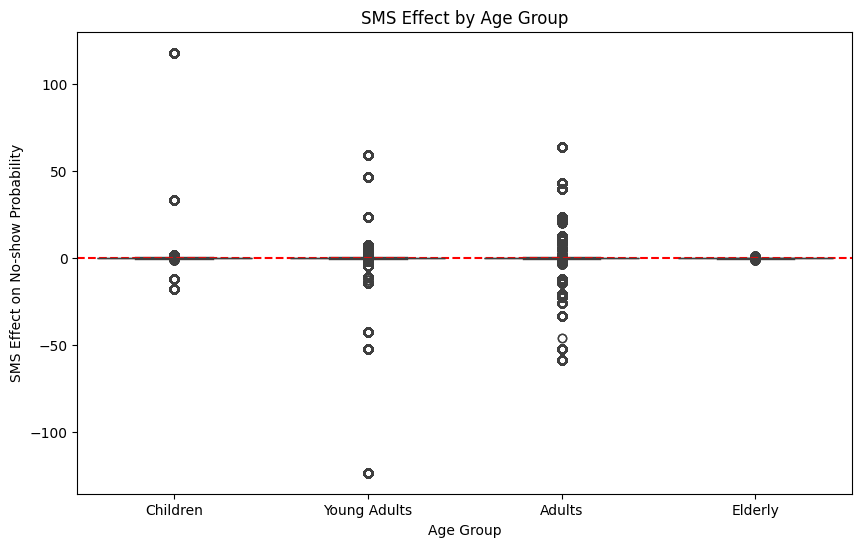

In [48]:
# 1.7 CATE by age groups
age_bins = [0, 18, 40, 65, 100]
age_labels = ['Children', 'Young Adults', 'Adults', 'Elderly']
train['AgeGroup'] = pd.cut(train['Age'], bins=age_bins, labels=age_labels)
cate_by_age = train.groupby('AgeGroup')['CATE_SMS'].mean()
print("\n1.5 Causal effect of SMS by age group:")
print(cate_by_age)

# 1.8 CATE by scholarship status
cate_by_scholarship = train.groupby('Scholarship')['CATE_SMS'].mean()
print("\n1.6 Causal effect of SMS by scholarship status:")
print(cate_by_scholarship)

# 1.9 Visualization of heterogeneous SMS effects
plt.figure(figsize=(10, 6))
sns.boxplot(x='AgeGroup', y='CATE_SMS', data=train)
plt.title('SMS Effect by Age Group')
plt.xlabel('Age Group')
plt.ylabel('SMS Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.savefig('sms_by_age_effects.png')
plt.show()

# Question 2: How do socioeconomic factors impact attendance?

In [ ]:
print("\n\n===============================================")
print("Question 2: How do socioeconomic factors impact attendance?")
print("===============================================")

# 2.1 Initial exploration
print("\n2.1 No-show rates by scholarship status:")
scholarship_groups = train.groupby('Scholarship')['No-show'].agg(['mean', 'count'])
print(scholarship_groups)

In [ ]:
# 2.2 Visualization of no-show rates by scholarship status
plt.figure(figsize=(10, 6))
sns.barplot(x='Scholarship', y='No-show', data=train, errorbar=('ci', 95))
plt.title('No-show Rate by Scholarship Status')
plt.xlabel('Scholarship (Welfare Program Enrollment)')
plt.ylabel('No-show Probability')
plt.xticks([0, 1], ['No Scholarship', 'Has Scholarship'])
plt.savefig('scholarship_noshow_plot.png')
plt.close()

In [ ]:
# 2.3 Fit Double Machine Learning estimator for scholarship
print("\n2.2 Double Machine Learning for scholarship effect:")
T_scholarship = train['Scholarship'].values

# For scholarship analysis, remove Scholarship from features
X_scholarship = X.drop('Scholarship', axis=1) if 'Scholarship' in X.columns else X

dml_scholarship = LinearDML(
    model_y=GradientBoostingRegressor(n_estimators=100, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)
dml_scholarship.fit(Y, T_scholarship, X=X_scholarship)

# Calculate ATE
ate_dml_scholarship = dml_scholarship.effect(X_scholarship)
print(f"Average Treatment Effect (Scholarship) from DML: {np.mean(ate_dml_scholarship):.4f}")

In [ ]:
# 2.4 Fit CATE estimator for scholarship
print("\n2.3 Forest-based Causal Model for scholarship effect:")
est_forest_scholarship = ForestDMLCateEstimator(
    model_y=GradientBoostingRegressor(n_estimators=100, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)
est_forest_scholarship.fit(Y, T_scholarship, X=X_scholarship)

# Calculate scholarship CATE
cate_scholarship = est_forest_scholarship.effect(X_scholarship)
train['CATE_Scholarship'] = cate_scholarship
print(f"Average Treatment Effect (Scholarship) from Forest: {np.mean(cate_scholarship):.4f}")

In [ ]:
# 2.5 Meta-learners for robustness
print("\n2.4 Meta-learners for scholarship effect (robustness check):")

# S-learner for scholarship
s_learner_scholarship = SLearner(learner=GradientBoostingRegressor(n_estimators=100, random_state=42))
s_learner_scholarship.fit(X_scholarship, T_scholarship, Y)
cate_s_scholarship = s_learner_scholarship.effect(X_scholarship)
print(f"ATE from S-learner: {np.mean(cate_s_scholarship):.4f}")

# X-learner for scholarship
x_learner_scholarship = XLearner(
    learner=GradientBoostingRegressor(n_estimators=100, random_state=42),
    propensity_model=LogisticRegression(max_iter=1000, random_state=42)
)
x_learner_scholarship.fit(X_scholarship, T_scholarship, Y)
cate_x_scholarship = x_learner_scholarship.effect(X_scholarship)
print(f"ATE from X-learner: {np.mean(cate_x_scholarship):.4f}")

In [ ]:
# 2.6 CATE by age groups and gender
cate_by_age_scholarship = train.groupby('AgeGroup')['CATE_Scholarship'].mean()
print("\n2.5 Causal effect of scholarship by age group:")
print(cate_by_age_scholarship)

cate_by_gender = train.groupby('Gender_Encoded')['CATE_Scholarship'].mean()
print("\n2.6 Causal effect of scholarship by gender:")
print(cate_by_gender)

# 2.7 Visualization of heterogeneous scholarship effects
plt.figure(figsize=(10, 6))
sns.boxplot(x='AgeGroup', y='CATE_Scholarship', data=train)
plt.title('Scholarship Effect by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Scholarship Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.savefig('scholarship_by_age_effects.png')
plt.close()


# Question 3: Does wait time significantly influence no-show behavior?


In [ ]:
print("\n\n===============================================")
print("Question 3: Does wait time significantly influence no-show behavior?")
print("===============================================")

# 3.1 Initial exploration
print("\n3.1 No-show rates by wait time group:")
waittime_groups = train.groupby('HighWaitTime')['No-show'].agg(['mean', 'count'])
print(waittime_groups)

# Create wait time bins for visualization
wait_bins = [0, 7, 14, 30, train['WaitTime'].max()]
wait_labels = ['0-7 days', '8-14 days', '15-30 days', '30+ days']
train['WaitTimeGroup'] = pd.cut(train['WaitTime'], bins=wait_bins, labels=wait_labels)

print("\n3.2 No-show rates by detailed wait time groups:")
detailed_wait_groups = train.groupby('WaitTimeGroup')['No-show'].agg(['mean', 'count'])
print(detailed_wait_groups)

In [ ]:
# 3.3 Visualization of no-show rates by wait time
plt.figure(figsize=(10, 6))
sns.barplot(x='WaitTimeGroup', y='No-show', data=train, errorbar=('ci', 95))
plt.title('No-show Rate by Wait Time')
plt.xlabel('Wait Time')
plt.ylabel('No-show Probability')
plt.savefig('waittime_noshow_plot.png')
plt.close()

# 3.4 Scatter plot of wait time vs. no-show with LOWESS curve
plt.figure(figsize=(10, 6))
sns.regplot(x='WaitTime', y='No-show', data=train,
            scatter_kws={'alpha': 0.3},
            lowess=True,
            line_kws={'color': 'red'})
plt.title('Relationship Between Wait Time and No-show Probability')
plt.xlabel('Wait Time (days)')
plt.ylabel('No-show Probability')
plt.savefig('waittime_scatter_plot.png')
plt.close()


In [ ]:
# 3.5 Fit Double Machine Learning estimator for wait time
print("\n3.3 Double Machine Learning for wait time effect:")
T_waittime = train['HighWaitTime'].values

# For wait time analysis, remove wait time related features from X
X_waittime = X.copy()
for col in X.columns:
    if 'WaitTime' in col:
        X_waittime = X_waittime.drop(col, axis=1)

dml_waittime = LinearDMLCateEstimator(
    model_y=GradientBoostingRegressor(n_estimators=100, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)
dml_waittime.fit(Y, T_waittime, X=X_waittime)

# Calculate ATE
ate_dml_waittime = dml_waittime.effect(X_waittime)
print(f"Average Treatment Effect (High Wait Time) from DML: {np.mean(ate_dml_waittime):.4f}")


In [ ]:
# 3.6 Fit CATE estimator for wait time
print("\n3.4 Forest-based Causal Model for wait time effect:")
est_forest_waittime = ForestDMLCateEstimator(
    model_y=GradientBoostingRegressor(n_estimators=100, random_state=42),
    model_t=GradientBoostingRegressor(n_estimators=100, random_state=42),
    discrete_treatment=True,
    random_state=42
)
est_forest_waittime.fit(Y, T_waittime, X=X_waittime)

# Calculate wait time CATE
cate_waittime = est_forest_waittime.effect(X_waittime)
train['CATE_WaitTime'] = cate_waittime
print(f"Average Treatment Effect (High Wait Time) from Forest: {np.mean(cate_waittime):.4f}")


In [ ]:
# 3.7 Meta-learners for robustness
print("\n3.5 Meta-learners for wait time effect (robustness check):")

# S-learner for wait time
s_learner_waittime = SLearner(learner=GradientBoostingRegressor(n_estimators=100, random_state=42))
s_learner_waittime.fit(X_waittime, T_waittime, Y)
cate_s_waittime = s_learner_waittime.effect(X_waittime)
print(f"ATE from S-learner: {np.mean(cate_s_waittime):.4f}")

# X-learner for wait time
x_learner_waittime = XLearner(
    learner=GradientBoostingRegressor(n_estimators=100, random_state=42),
    propensity_model=LogisticRegression(max_iter=1000, random_state=42)
)
x_learner_waittime.fit(X_waittime, T_waittime, Y)
cate_x_waittime = x_learner_waittime.effect(X_waittime)
print(f"ATE from X-learner: {np.mean(cate_x_waittime):.4f}")

In [ ]:
# 3.8 CATE by age groups and scholarship status
cate_by_age_waittime = train.groupby('AgeGroup')['CATE_WaitTime'].mean()
print("\n3.6 Causal effect of high wait time by age group:")
print(cate_by_age_waittime)

cate_by_scholarship_waittime = train.groupby('Scholarship')['CATE_WaitTime'].mean()
print("\n3.7 Causal effect of high wait time by scholarship status:")
print(cate_by_scholarship_waittime)

# 3.9 Visualization of heterogeneous wait time effects
plt.figure(figsize=(10, 6))
sns.boxplot(x='AgeGroup', y='CATE_WaitTime', data=train)
plt.title('Wait Time Effect by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Wait Time Effect on No-show Probability')
plt.axhline(y=0, color='r', linestyle='--')
plt.savefig('waittime_by_age_effects.png')
plt.close()


In [ ]:
# =======================================================
# Combined Analysis and Interactions
# =======================================================
print("\n\n===============================================")
print("Combined Analysis and Interactions")
print("===============================================")

# 4.1 Interaction between SMS and Wait Time
print("\n4.1 Interaction between SMS and Wait Time:")
interaction_sms_wait = train.groupby(['SMS_received', 'HighWaitTime'])['No-show'].mean().unstack()
print(interaction_sms_wait)

# Visualize interaction
plt.figure(figsize=(10, 6))
sns.barplot(x='HighWaitTime', y='No-show', hue='SMS_received', data=train, errorbar=('ci', 95))
plt.title('Interaction Between SMS and Wait Time on No-show Rate')
plt.xlabel('High Wait Time')
plt.ylabel('No-show Probability')
plt.legend(title='SMS Received')
plt.savefig('sms_waittime_interaction.png')
plt.close()


In [ ]:
# 4.2 Interaction between SMS and Scholarship
print("\n4.2 Interaction between SMS and Scholarship:")
interaction_sms_scholarship = train.groupby(['SMS_received', 'Scholarship'])['No-show'].mean().unstack()
print(interaction_sms_scholarship)

# Visualize interaction
plt.figure(figsize=(10, 6))
sns.barplot(x='Scholarship', y='No-show', hue='SMS_received', data=train, errorbar=('ci', 95))
plt.title('Interaction Between SMS and Scholarship on No-show Rate')
plt.xlabel('Scholarship Status')
plt.ylabel('No-show Probability')
plt.legend(title='SMS Received')
plt.savefig('sms_scholarship_interaction.png')
plt.close()


In [ ]:
# 4.3 Summary of Causal Effects and Policy Implications
print("\n4.3 Summary of Causal Effects from Multiple Methods:")

# Consolidate all estimates for each treatment
all_sms_effects = [np.mean(ate_dml_sms), np.mean(cate_sms), np.mean(cate_s), np.mean(cate_t), np.mean(cate_x)]
all_scholarship_effects = [np.mean(ate_dml_scholarship), np.mean(cate_scholarship), np.mean(cate_s_scholarship), np.mean(cate_x_scholarship)]
all_waittime_effects = [np.mean(ate_dml_waittime), np.mean(cate_waittime), np.mean(cate_s_waittime), np.mean(cate_x_waittime)]

print(f"SMS Reminder Effect: Mean = {np.mean(all_sms_effects):.4f}, Range = [{min(all_sms_effects):.4f}, {max(all_sms_effects):.4f}]")
print(f"Scholarship Effect: Mean = {np.mean(all_scholarship_effects):.4f}, Range = [{min(all_scholarship_effects):.4f}, {max(all_scholarship_effects):.4f}]")
print(f"High Wait Time Effect: Mean = {np.mean(all_waittime_effects):.4f}, Range = [{min(all_waittime_effects):.4f}, {max(all_waittime_effects):.4f}]")

# Use the mean across methods for policy implications
avg_sms_effect = np.mean(all_sms_effects)
avg_scholarship_effect = np.mean(all_scholarship_effects)
avg_waittime_effect = np.mean(all_waittime_effects)

print("\n4.4 Policy Implications:")
print("1. SMS Effectiveness: ", end="")
if avg_sms_effect < 0:
    print(f"SMS reminders reduce no-show rates by {-avg_sms_effect*100:.2f}%")
else:
    print(f"SMS reminders do not effectively reduce no-show rates")

print("2. Socioeconomic Factors: ", end="")
if avg_scholarship_effect > 0:
    print(f"Patients with welfare support (scholarship) have {avg_scholarship_effect*100:.2f}% higher no-show rates")
    print("   → Consider providing additional support like transportation vouchers")
else:
    print(f"Welfare program enrollment reduces no-show rates by {-avg_scholarship_effect*100:.2f}%")

print("3. Wait Time Management: ", end="")
if avg_waittime_effect > 0:
    print(f"Longer wait times increase no-show rates by {avg_waittime_effect*100:.2f}%")
    print("   → Prioritize reducing appointment waiting times")
else:
    print(f"Wait time does not significantly affect no-show rates")

In [ ]:
# 4.5 Find optimal targeting strategy
print("\n4.5 Optimal SMS Targeting Strategy:")
# Find groups that benefit most from SMS
high_benefit_threshold = np.percentile(cate_sms, 25)  # Lower values mean more reduction
high_benefit_group = train[cate_sms < high_benefit_threshold]

print(f"Profile of patients who benefit most from SMS reminders (top 25%):")
benefit_profile = high_benefit_group[['Age', 'Gender_Encoded', 'Hipertension',
                                     'Diabetes', 'Scholarship', 'WaitTime']].describe()
print(benefit_profile)

# Save the final results
train[['PatientId', 'CATE_SMS', 'CATE_Scholarship', 'CATE_WaitTime']].to_csv('causal_effects_results.csv', index=False)

print("\nCausal analysis complete. All results and visualizations have been saved.")